In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale


import random
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
SpkCtx = SparkSession.builder.getOrCreate()
df_Covid = SpkCtx.read.option('header', 'true').csv('time_series_covid19_confirmed_global.csv', inferSchema= True)

# Clean and Preprocesing Data

First of all we do an exploratory analysis of the dataset to have information about the columns it has, the rows and the type of information it contains. Below we can see that it contains 289 rows that correspond to different countries and states and 1147 columns, the first 4 indicate the location of the count and the rest is the number of Covid-19 infected per day.

In [4]:
df_Covid.toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/01/2023,3/02/2023,3/03/2023,3/04/2023,3/05/2023,3/06/2023,3/07/2023,3/08/2023,3/09/2023
0,None,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,None,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,None,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,None,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,None,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,None,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,None,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,None,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,None,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


Since the analysis of the countries with the most affected by Covid-19 will be carried out. We are going to proceed to eliminate the columns with data that we do not need, such as 'Province/State', 'Lat' and 'Long'.

In [5]:
py_covid = df_Covid.drop('Province/State', 'Lat', 'Long')
py_covid.toPandas()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/01/2023,3/02/2023,3/03/2023,3/04/2023,3/05/2023,3/06/2023,3/07/2023,3/08/2023,3/09/2023
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,Albania,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,Algeria,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,Andorra,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,Angola,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,Winter Olympics 2022,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,Yemen,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,Zambia,0,0,0,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


Since it has been observed that the counts of some countries have been reported by provinces or states, and the analysis is going to be carried out by country, the rows that are from the same country will be grouped into a single row by country. Below you can see how, for example, 'China', 'Canada' or 'United Kingdom' are repeated in several rows, so they will be grouped into a single one.

In [6]:
py_covid.groupBy('Country/Region').count().orderBy('count', ascending=False).show()

+--------------+-----+
|Country/Region|count|
+--------------+-----+
|         China|   34|
|        Canada|   16|
|United Kingdom|   15|
|        France|   12|
|     Australia|    8|
|   Netherlands|    5|
|       Denmark|    3|
|   New Zealand|    3|
|          Chad|    1|
|      Paraguay|    1|
|         Yemen|    1|
|        Sweden|    1|
|        Russia|    1|
|  Korea, North|    1|
|       Senegal|    1|
|      Kiribati|    1|
|        Guyana|    1|
|       Eritrea|    1|
|    Cabo Verde|    1|
|         Burma|    1|
+--------------+-----+
only showing top 20 rows



In [7]:
group_countries = py_covid.groupBy('Country/Region').sum()
group_countries.toPandas()

,Country/Region,sum(1/22/20),sum(1/23/20),sum(1/24/20),sum(1/25/20),sum(1/26/20),sum(1/27/20),sum(1/28/20),sum(1/29/20),sum(1/30/20),...,sum(2/28/23),sum(3/01/2023),sum(3/02/2023),sum(3/03/2023),sum(3/04/2023),sum(3/05/2023),sum(3/06/2023),sum(3/07/2023),sum(3/08/2023),sum(3/09/2023)
0,Chad,0,0,0,0,0,0,0,0,0,...,7678,7678,7678,7678,7678,7678,7678,7679,7679,7679
1,Paraguay,0,0,0,0,0,0,0,0,0,...,808327,808327,808327,808401,808401,808401,808401,808401,808401,808401
2,Russia,0,0,0,0,0,0,0,0,0,...,21960719,21974098,21988110,22002485,22016406,22029824,22040875,22051220,22063473,22075858
3,Yemen,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
4,"Korea, North",0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Vietnam,0,2,2,2,2,2,2,2,2,...,11526917,11526926,11526937,11526950,11526962,11526966,11526966,11526986,11526994,11526994
197,Winter Olympics 2022,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
198,Diamond Princess,0,0,0,0,0,0,0,0,0,...,712,712,712,712,712,712,712,712,712,712
199,Mali,0,0,0,0,0,0,0,0,0,...,33018,33034,33045,33051,33051,33053,33056,33059,33061,33062


### Null Values
Before continuing with the preparation of the data, we are going to process the null values with the .isnull function of Pandas, and in the case of exiting null values, eliminate them.

In [8]:
pd_covid = group_countries.toPandas()

In [9]:
print(pd_covid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Columns: 1144 entries, Country/Region to sum(3/09/2023)
dtypes: int64(1143), object(1)
memory usage: 1.8+ MB
None


In [10]:
print(pd_covid.isnull().sum())

Country/Region    0
sum(1/22/20)      0
sum(1/23/20)      0
sum(1/24/20)      0
sum(1/25/20)      0
                 ..
sum(3/05/2023)    0
sum(3/06/2023)    0
sum(3/07/2023)    0
sum(3/08/2023)    0
sum(3/09/2023)    0
Length: 1144, dtype: int64


### Grouped columns

Next, the columns of the dataset will be renamed with the original name to make it easier to use in the analysis.

In [11]:
columns = pd_covid.columns.str[4:-1]
pd_covid.columns = columns
pd_covid = pd_covid.rename(columns={pd_covid.columns[0]: 'Country'})
print(pd_covid)

                  Country  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0                    Chad        0        0        0        0        0   
1                Paraguay        0        0        0        0        0   
2                  Russia        0        0        0        0        0   
3                   Yemen        0        0        0        0        0   
4            Korea, North        0        0        0        0        0   
..                    ...      ...      ...      ...      ...      ...   
196               Vietnam        0        2        2        2        2   
197  Winter Olympics 2022        0        0        0        0        0   
198      Diamond Princess        0        0        0        0        0   
199                  Mali        0        0        0        0        0   
200           Netherlands        0        0        0        0        0   

     1/27/20  1/28/20  1/29/20  1/30/20  ...   2/28/23  3/01/2023  3/02/2023  \
0          0        0        0 

### Unify date formats
Since there are dates with different formats, some with 2 digits in the year and others with 4 digits, a single format will be used.

In [12]:
pd_covid.dtypes

Country      object
1/22/20       int64
1/23/20       int64
1/24/20       int64
1/25/20       int64
              ...  
3/05/2023     int64
3/06/2023     int64
3/07/2023     int64
3/08/2023     int64
3/09/2023     int64
Length: 1144, dtype: object

First, we are going to play with the dataset indicating that the 'Country' column is the index to be able to modify the completed dataset more easily.

In [13]:
# setting the column 'Country' as index in the dataset with the method .set_index
pd_covid=pd_covid.set_index('Country')

In [14]:
# The columns are converted to date objects in the same format and the columns are renamed with the new name.
date_formats = pd.to_datetime(pd_covid.columns, infer_datetime_format=True).strftime('%Y-%m-%d')

new_columns = {col: date_formats[i] for i, col in enumerate(pd_covid.columns)}

pd_covid.rename(columns=new_columns, inplace=True)

In [15]:
print(pd_covid)

                      2020-01-22  2020-01-23  2020-01-24  2020-01-25  \
Country                                                                
Chad                           0           0           0           0   
Paraguay                       0           0           0           0   
Russia                         0           0           0           0   
Yemen                          0           0           0           0   
Korea, North                   0           0           0           0   
...                          ...         ...         ...         ...   
Vietnam                        0           2           2           2   
Winter Olympics 2022           0           0           0           0   
Diamond Princess               0           0           0           0   
Mali                           0           0           0           0   
Netherlands                    0           0           0           0   

                      2020-01-26  2020-01-27  2020-01-28  2020-

### Grouped dates in weeks


In [16]:
# Transpose the dataset to group the dates in weeks with the rersample method of Pandas.
pd_covid=pd_covid.T

In [17]:
# Create the index of the dataset in datetime object
pd_covid.index = pd.to_datetime(pd_covid.index)

In [18]:
# Resamples the dataset in group of 7 days. 
weekly_covid = pd_covid.resample('7D', closed='left', label='left', loffset='1D').sum()

# Rename the group for 'Week 1', 'Week 2', 'Week 3', ....
weekly_covid.index = [f'week {i}' for i in range(1, len(weekly_covid.index) + 1)]

C:\Users\bbern\AppData\Local\Temp\ipykernel_7696\3293267207.py:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  weekly_covid = pd_covid.resample('7D', closed='left', label='left', loffset='1D').sum()


In [19]:
weekly_covid = weekly_covid.T
print(weekly_covid)

                      week 1  week 2  week 3  week 4  week 5  week 6  week 7  \
Country                                                                        
Chad                       0       0       0       0       0       0       0   
Paraguay                   0       0       0       0       0       0       7   
Russia                     0      10      14      14      14      16      87   
Yemen                      0       0       0       0       0       0       0   
Korea, North               0       0       0       0       0       0       0   
...                      ...     ...     ...     ...     ...     ...     ...   
Vietnam                   12      34      83     111     112     112     157   
Winter Olympics 2022       0       0       0       0       0       0       0   
Diamond Princess           0       0     456    2204    4596    4936    4942   
Mali                       0       0       0       0       0       0       0   
Netherlands                0       0    

In [20]:
# The dataset is transposed again to add the columns and obtain the total number of infected by country.
weekly_covid=weekly_covid.T

### Summarize the total number of infected per country

In [21]:
#All the values of the weeks of each country are added to have the total number of infected
#The total number of infectes is ordered in descending order.
top_countries = weekly_covid.sum()
top_countries.sort_values(ascending=False)

Country
US                      53813184406
India                   29131119694
Brazil                  21182690594
France                  16105911886
Germany                 13686043720
                           ...     
Winter Olympics 2022         214462
Holy See                      26807
MS Zaandam                     9665
Antarctica                     4961
Korea, North                    300
Length: 201, dtype: int64

In [22]:
print(top_countries.dtypes)

int64


In [23]:
# the 'Country' column is returned as a column to the dataset.
weekly_covid = weekly_covid.reset_index()

In [24]:
print(weekly_covid)

Country     index   Chad  Paraguay     Russia  Yemen  Korea, North  Senegal  \
0          week 1      0         0          0      0             0        0   
1          week 2      0         0         10      0             0        0   
2          week 3      0         0         14      0             0        0   
3          week 4      0         0         14      0             0        0   
4          week 5      0         0         14      0             0        0   
..            ...    ...       ...        ...    ...           ...      ...   
159      week 160  53582   5647146  152245590  83615             7   622322   
160      week 161  53655   5650845  152878344  83615             7   622370   
161      week 162  53731   5656541  153506728  83615             7   622419   
162      week 163  53747   5658659  154103018  83615             7   622447   
163      week 164  15358   1616802   44139331  23890             2   177852   

Country  Cabo Verde    Sweden  Kiribati  ...  Pakis

### Top three countries

In [25]:
# create a new variable with the 3 most infected countries.
tops = weekly_covid[['index','US','India','Brazil']]
print(tops)

Country     index         US      India     Brazil
0          week 1         21          0          0
1          week 2         58         11          0
2          week 3         84         21          0
3          week 4         97         21          0
4          week 5        108         21          0
..            ...        ...        ...        ...
159      week 160  719999991  312795666  258490660
160      week 161  721846509  312802859  258863194
161      week 162  723659953  312810648  259159031
162      week 163  725416580  312823100  259522661
163      week 164  207558473   89381036   74152106

[164 rows x 4 columns]


# Predictived Model

### Correlation variables

In [26]:
# Firstly, converter the column of index in numeric for the model with the method .extract() for extrating the numeric
tops['index'] = tops['index'].str.extract('(\d+)', expand=False).astype(int)


C:\Users\bbern\AppData\Local\Temp\ipykernel_7696\3294397040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tops['index'] = tops['index'].str.extract('(\d+)', expand=False).astype(int)


In [27]:
tops.head(5)

Country,index,US,India,Brazil
0,1,21,0,0
1,2,58,11,0
2,3,84,21,0
3,4,97,21,0
4,5,108,21,0


### lineal graph 3 tops countries

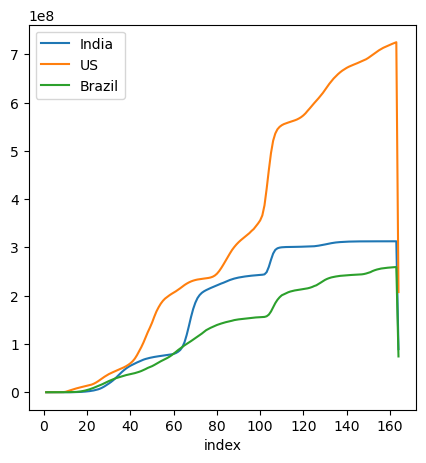

In [28]:
fig, ax = plt.subplots(1, figsize=(5,5))
tops.plot(x='index', y='India', ax=ax, label='India')
tops.plot(x='index', y='US', ax=ax, label='US')
tops.plot(x='index', y='Brazil', ax=ax, label='Brazil')
ax.legend()
plt.show()

### Scatter graph US

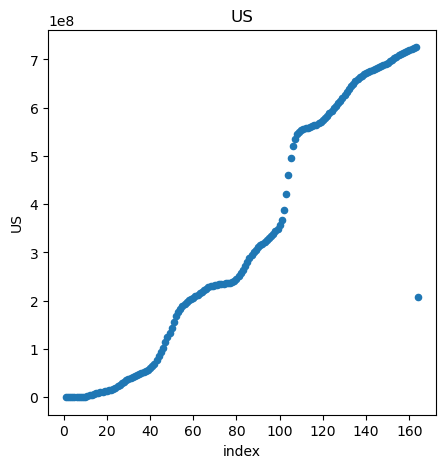

In [33]:
fig, ax = plt.subplots(1, figsize=(5,5))
tops.plot.scatter(x='index', y='US', ax=ax)
ax.set_title('US')
plt.show()

### Scatter graph India

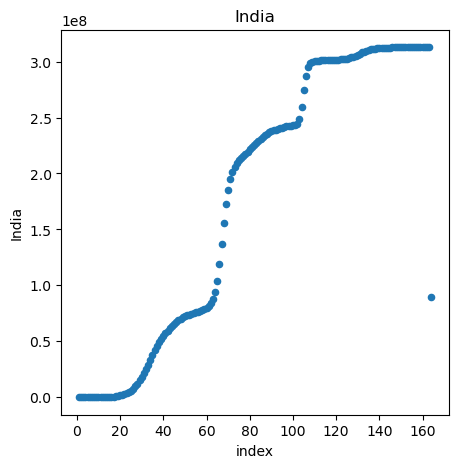

In [34]:
fig, ax = plt.subplots(1, figsize=(5,5))
tops.plot.scatter(x='index', y='India', ax=ax)
ax.set_title('India')
plt.show()

### Scatter graph Brazil

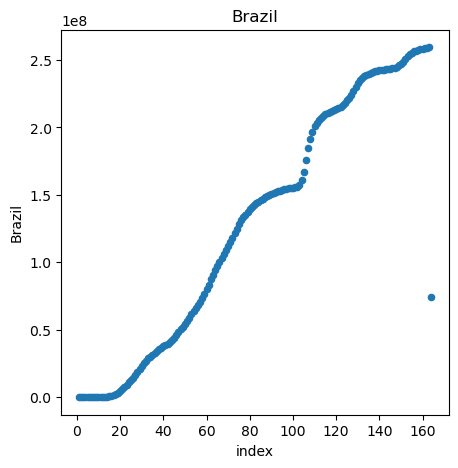

In [35]:
fig, ax = plt.subplots(1, figsize=(5,5))
tops.plot.scatter(x='index', y='Brazil', ax=ax)
ax.set_title('Brazil')
plt.show()

### Linear Regression Model - US

Since we only have the variables of the total number of Covid-19 cases per week and the week variable, we are going to proceed to create a simple Linear regression model.

### Equation

y = a + bx

In [40]:
#First of all we are going to convert the variable in pyspark to create the model

df_tops = SpkCtx.createDataFrame(tops)

df_tops.show()

C:\Users\bbern\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\bbern\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+-----+--------+-------+-------+
|index|      US|  India| Brazil|
+-----+--------+-------+-------+
|    1|      21|      0|      0|
|    2|      58|     11|      0|
|    3|      84|     21|      0|
|    4|      97|     21|      0|
|    5|     108|     21|      0|
|    6|     236|     25|     11|
|    7|    2826|    261|    110|
|    8|   22333|    693|   1075|
|    9|  206641|   2355|   8524|
|   10|  889494|   6930|  27412|
|   11| 2258539|  23867|  71621|
|   12| 3789077|  59830| 145511|
|   13| 5191282| 112060| 251561|
|   14| 6612223| 183925| 412941|
|   15| 7962134| 283223| 682075|
|   16| 9191072| 444062|1075846|
|   17|10291818| 638985|1615437|
|   18|11376435| 920750|2433558|
|   19|12382649|1274960|3442962|
|   20|13424074|1725903|4691063|
+-----+--------+-------+-------+
only showing top 20 rows



In [41]:
df_tops.dtypes

[('index', 'bigint'),
 ('US', 'bigint'),
 ('India', 'bigint'),
 ('Brazil', 'bigint')]

In [42]:
# Assembler the vector features of all models.
index_assembler = VectorAssembler(inputCols=['index'], outputCol='feature')


df_US = index_assembler.transform(df_tops).select(['feature', 'US'])
df_India = index_assembler.transform(df_tops).select(['feature', 'India'])
df_Brazil = index_assembler.transform(df_tops).select(['feature', 'Brazil'])

df_US.show()
df_India.show()
df_Brazil.show()



+-------+--------+
|feature|      US|
+-------+--------+
|  [1.0]|      21|
|  [2.0]|      58|
|  [3.0]|      84|
|  [4.0]|      97|
|  [5.0]|     108|
|  [6.0]|     236|
|  [7.0]|    2826|
|  [8.0]|   22333|
|  [9.0]|  206641|
| [10.0]|  889494|
| [11.0]| 2258539|
| [12.0]| 3789077|
| [13.0]| 5191282|
| [14.0]| 6612223|
| [15.0]| 7962134|
| [16.0]| 9191072|
| [17.0]|10291818|
| [18.0]|11376435|
| [19.0]|12382649|
| [20.0]|13424074|
+-------+--------+
only showing top 20 rows

+-------+-------+
|feature|  India|
+-------+-------+
|  [1.0]|      0|
|  [2.0]|     11|
|  [3.0]|     21|
|  [4.0]|     21|
|  [5.0]|     21|
|  [6.0]|     25|
|  [7.0]|    261|
|  [8.0]|    693|
|  [9.0]|   2355|
| [10.0]|   6930|
| [11.0]|  23867|
| [12.0]|  59830|
| [13.0]| 112060|
| [14.0]| 183925|
| [15.0]| 283223|
| [16.0]| 444062|
| [17.0]| 638985|
| [18.0]| 920750|
| [19.0]|1274960|
| [20.0]|1725903|
+-------+-------+
only showing top 20 rows

+-------+-------+
|feature| Brazil|
+-------+-------+
|  [1.

In [43]:
#Split the data en training and test data

df_training_US, df_test_US = df_US.randomSplit([0.7, 0.3])
df_training_India, df_test_India = df_India.randomSplit([0.7, 0.3])
df_training_Brazil, df_test_Brazil = df_Brazil.randomSplit([0.7, 0.3])

### linear regresion simple US

In [44]:
#fit the model
prUS= LinearRegression(featuresCol='feature', labelCol='US', maxIter=30)

prModelUS = prUS.fit(df_training_US)

print('Coefficient: ' + str(prModelUS.coefficients))
print('Intercept:' + str(prModelUS.intercept))

print('r2: ', prModelUS.summary.r2)

Coefficient: [5204024.955313316]
Intercept:-101696706.83338301
r2:  0.9285118864825823


In [45]:
prUS=prModelUS.transform(df_test_US)
#evaluate the model using R-squared metric
evaluatorUS=RegressionEvaluator(labelCol='US', predictionCol='prediction', metricName='r2')

r2=evaluatorUS.evaluate(prUS)
print('R-squares on test data : %.3f' %r2)

R-squares on test data : 0.965


### linear regresion simple India

In [46]:
#fit the model
prIndia= LinearRegression(featuresCol='feature', labelCol='India', maxIter=30)

prModelIndia = prIndia.fit(df_training_India)

print('Coefficient: ' + str(prModelIndia.coefficients))
print('Intercept:' + str(prModelIndia.intercept))

print('r2: ', prModelIndia.summary.r2)

Coefficient: [2458033.6498732315]
Intercept:-21512296.26163105
r2:  0.8692266771127998


In [48]:
prIndia=prModelIndia.transform(df_test_India)
#evaluate the model using R-squared metric
evaluatorIndia=RegressionEvaluator(labelCol='India', predictionCol='prediction', metricName='r2')

r2=evaluatorIndia.evaluate(prIndia)
print('R-squares on test data : %.3f' %r2)

R-squares on test data : 0.926


### linear regresion simple Brazil

In [49]:
#fit the model
prBrazil= LinearRegression(featuresCol='feature', labelCol='Brazil', maxIter=30)

prModelBrazil = prBrazil.fit(df_training_Brazil)

print('Coefficient: ' + str(prModelBrazil.coefficients))
print('Intercept:' + str(prModelBrazil.intercept))

print('r2: ', prModelBrazil.summary.r2)

Coefficient: [1835205.8791533737]
Intercept:-24205648.734268904
r2:  0.9372382955135391


In [50]:
prBrazil=prModelBrazil.transform(df_test_Brazil)
#evaluate the model using R-squared metric
evaluatorBrazil=RegressionEvaluator(labelCol='Brazil', predictionCol='prediction', metricName='r2')

r2=evaluatorBrazil.evaluate(prBrazil)
print('R-squares on test data : %.3f' %r2)

R-squares on test data : 0.977


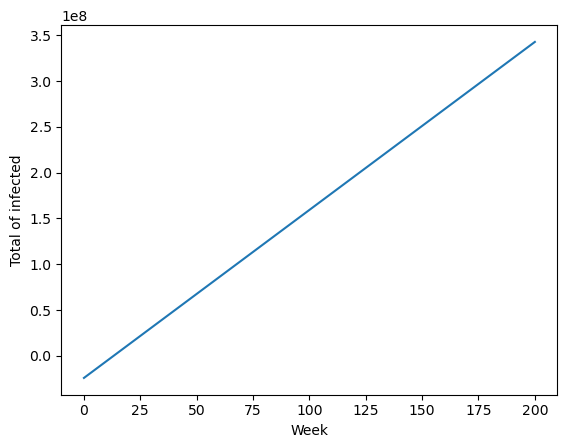

In [69]:
x = np.linspace(0,200,200)
y=prModelBrazil.coefficients[0] * x + prModelBrazil.intercept
plt.plot(x,y)
plt.xlabel('Week')
plt.ylabel('Total of infected')
plt.show()

A linear regression model has been carried out for the three countries with the most infected with Covid-19. The most accurate model is the model made for Brazil. The model indicates that each week the cases of Covid-19 increase by 1,819,935 million. The R-squared obtained with the test data is 98.6% accurate. Therefore, this model will be chosen to continue with the analysis.

# Clustering

In [71]:
#selecting the columns that we are going to use in the cluster.
df_brazil = df_tops.select('index', 'Brazil').toPandas()
df_brazil.head(5)

,index,Brazil
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [72]:
df_brazil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   164 non-null    int64
 1   Brazil  164 non-null    int64
dtypes: int64(2)
memory usage: 2.7 KB


## Method elbow

To determine the optimal number of clusters for the dataset, we will perform the 'elbow' method. The data will be grouped into 10 clusters and then it will be visualized how the SSE varies as the cluster increases.
With this we will obtain a graph that will mark each point, and it will be possible to visualize where the SSE begins to stabilize, which corresponds to the optimal number of clusters.


C:\Users\bbern\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bbern\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bbern\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bbern\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

Text(0, 0.5, 'Inertia')

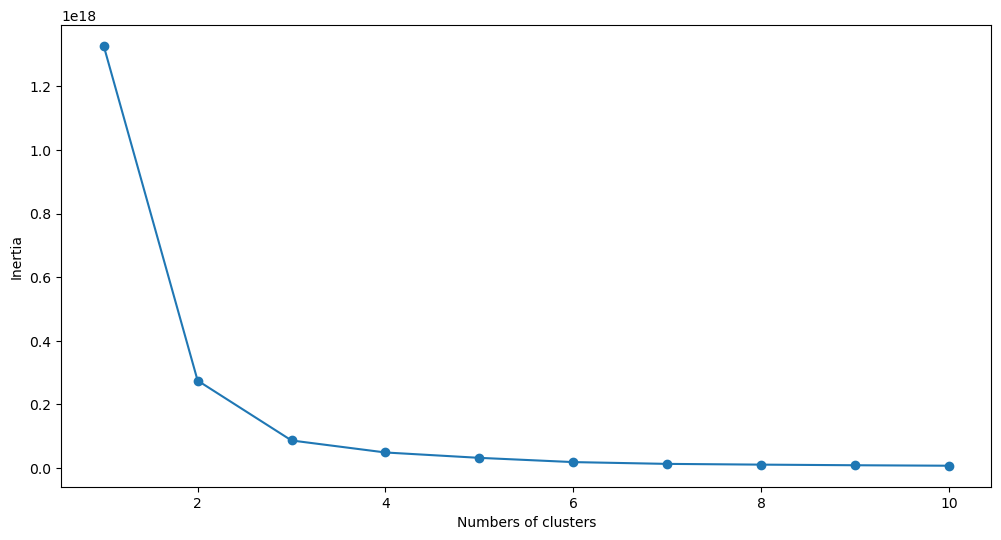

In [73]:
#I choose the column that we want to cluster (Brazil) and transform it to a two-dimensional matrix.
x = df_brazil['Brazil'].values.reshape(-1,1)

#We create an empty list to add the SSE values
SSE=[]
#Next, the data will be evaluated by the SSE with 10 clusters and the model will be adjusted with the data of the variable 'x'
for cluster in range(1,11):
    model = KMeans(n_clusters=cluster, init='k-means++')
    model.fit(x)
    SSE.append(model.inertia_)

frame = pd.DataFrame({'Cluster' : range(1,11), 'SSE':SSE})    
    
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Numbers of clusters')
plt.ylabel('Inertia')


## K-Means
In the previous graph it is observed how the stabilization of the SSE begins at point 3. Therefore, the data will be grouped into 3 clusters.

C:\Users\bbern\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bbern\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]


C:\Users\bbern\AppData\Local\Temp\ipykernel_7696\473104755.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(df_brazil['index'], df_brazil['Brazil'], c=model.labels_.astype(np.int))


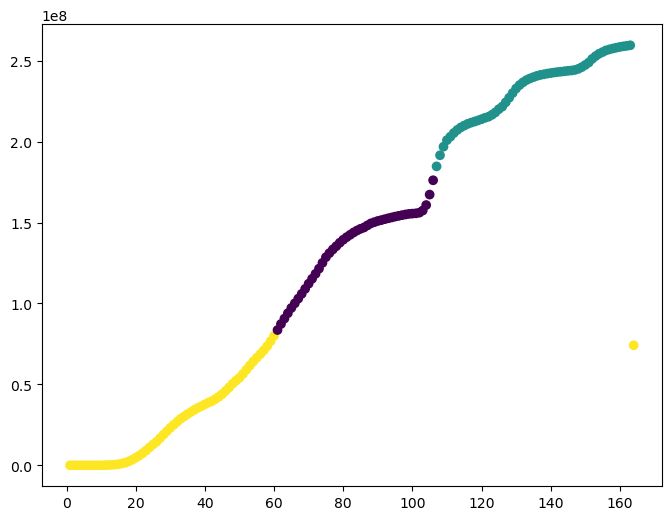

In [74]:
model = KMeans(n_clusters=3)

model = model.fit(x)

#We can look at the clusters each data point was assigned to 
print(model.labels_)

#And we will visualize it:
plt.figure(figsize = (8,6))
plt.scatter(df_brazil['index'], df_brazil['Brazil'], c=model.labels_.astype(np.int))
plt.show()

In the previous graph, 3 clusters are observed. Cluster 1 integrates the data from week 0 to week 65, cluster 2 from week 66 to 115, and cluster 3 from week 116 to 164.


## Graph Analytics

In [77]:
neighbors = weekly_covid[['Brazil','Bolivia', 'Paraguay', 'Uruguay', 'Argentina','Colombia', 'Venezuela']]
weeks= weekly_covid['index']
print(neighbors)
print(weeks)

Country     Brazil  Bolivia  Paraguay  Uruguay  Argentina  Colombia  Venezuela
0                0        0         0        0          0         0          0
1                0        0         0        0          0         0          0
2                0        0         0        0          0         0          0
3                0        0         0        0          0         0          0
4                0        0         0        0          0         0          0
..             ...      ...       ...      ...        ...       ...        ...
159      258490660  8335588   5647146  7233356   70285917  44489459    3862010
160      258863194  8343311   5650845  7236922   70297296  44495276    3863318
161      259159031  8348681   5656541  7238836   70304790  44498801    3863734
162      259522661  8356086   5658659  7240121   70310539  44507624    3864370
163       74152106  2388464   1616802  2068606   20089914  12718186    1104319

[164 rows x 7 columns]
0        week 1
1        wee

In [78]:
df_southAmerica = weekly_covid[['index', 'Brazil','Bolivia', 'Paraguay', 'Uruguay', 'Argentina','Colombia', 'Venezuela']]
#df_southAmerica.set_index('index', inplace=True)
print(df_southAmerica)

Country     index     Brazil  Bolivia  Paraguay  Uruguay  Argentina  Colombia  \
0          week 1          0        0         0        0          0         0   
1          week 2          0        0         0        0          0         0   
2          week 3          0        0         0        0          0         0   
3          week 4          0        0         0        0          0         0   
4          week 5          0        0         0        0          0         0   
..            ...        ...      ...       ...      ...        ...       ...   
159      week 160  258490660  8335588   5647146  7233356   70285917  44489459   
160      week 161  258863194  8343311   5650845  7236922   70297296  44495276   
161      week 162  259159031  8348681   5656541  7238836   70304790  44498801   
162      week 163  259522661  8356086   5658659  7240121   70310539  44507624   
163      week 164   74152106  2388464   1616802  2068606   20089914  12718186   

Country  Venezuela  
0     

In [81]:
df_SAmerica=df_southAmerica.T

In [82]:
print(df_SAmerica)

              0       1       2       3       4       5       6       7    \
Country                                                                     
index      week 1  week 2  week 3  week 4  week 5  week 6  week 7  week 8   
Brazil          0       0       0       0       0      11     110    1075   
Bolivia         0       0       0       0       0       0       0      49   
Paraguay        0       0       0       0       0       0       7      53   
Uruguay         0       0       0       0       0       0       0      97   
Argentina       0       0       0       0       0       1      53     272   
Colombia        0       0       0       0       0       0       7     219   
Venezuela       0       0       0       0       0       0       0      62   

              8        9    ...        154        155        156        157  \
Country                     ...                                               
index      week 9  week 10  ...   week 155   week 156   week 157   week

### Trend COVID-19 by country

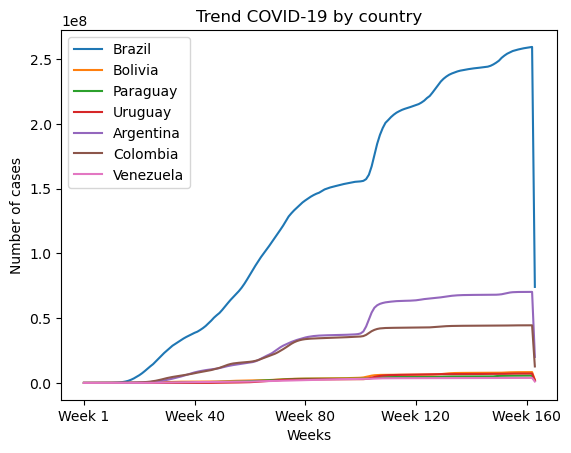

In [92]:
fig, ax = plt.subplots()
for country in neighbors.columns:
    ax.plot(weeks, neighbors[country], label=country)

    
ax.set_xticks([0, 40, 80, 120, 160])
ax.set_xticklabels(['Week 1', 'Week 40', 'Week 80', 'Week 120', 'Week 160'])

ax.set_xlabel('Weeks')
ax.set_ylabel('Number of cases')
ax.set_title('Trend COVID-19 by country')
ax.legend()
plt.show()

### Area of infected

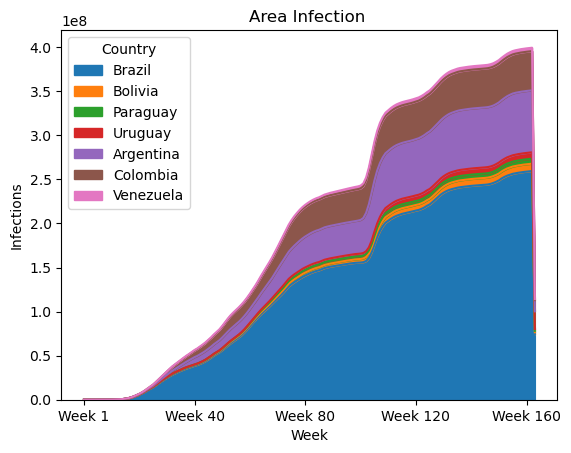

In [91]:
ax=neighbors.plot.area()
ax.set_xticks([0, 40, 80, 120, 160])
ax.set_xticklabels(['Week 1', 'Week 40', 'Week 80', 'Week 120', 'Week 160'])
plt.xlabel('Week')
plt.ylabel('Infections')
plt.title('Area Infection ')
plt.show()

### Correlation between countries.

<Axes: xlabel='Country', ylabel='Country'>

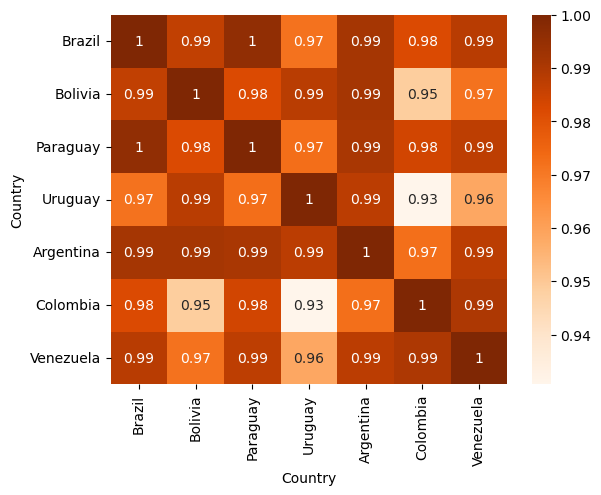

In [99]:
sb.heatmap(neighbors.corr(), cmap='Oranges', annot=True)

### Scatter Matrix

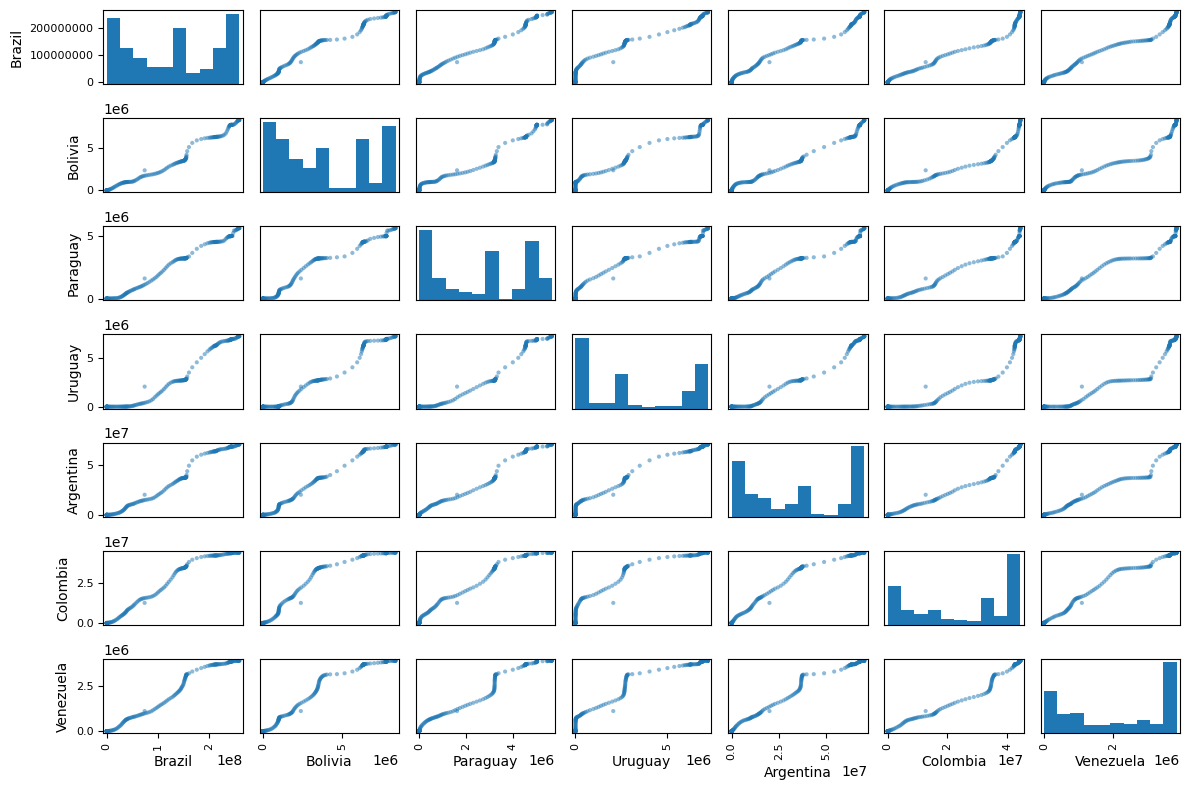

In [78]:
numeric_columns = df_southAmerica.select_dtypes(include=[int, float])


pd.plotting.scatter_matrix(numeric_columns, figsize=(12, 8))

plt.tight_layout()

plt.show()

### Scatter graph of each country

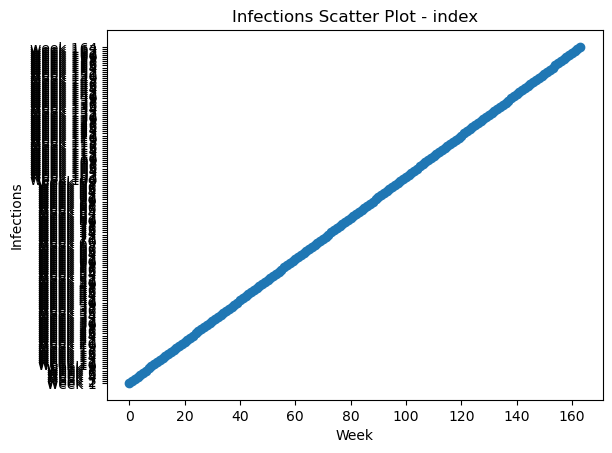

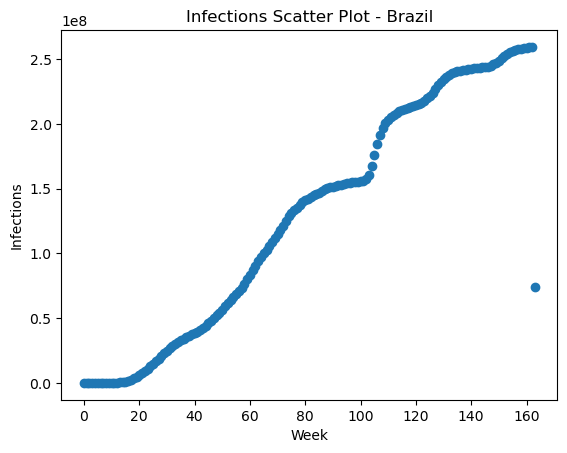

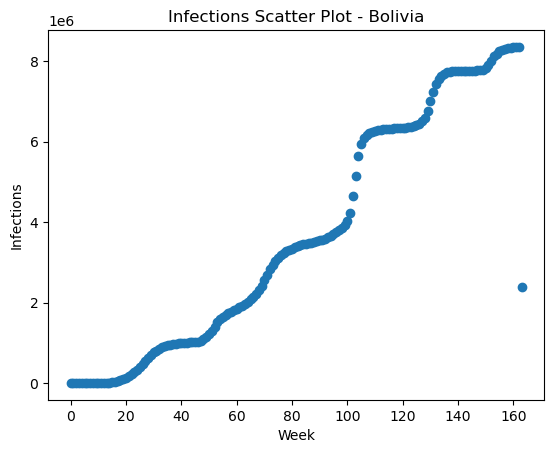

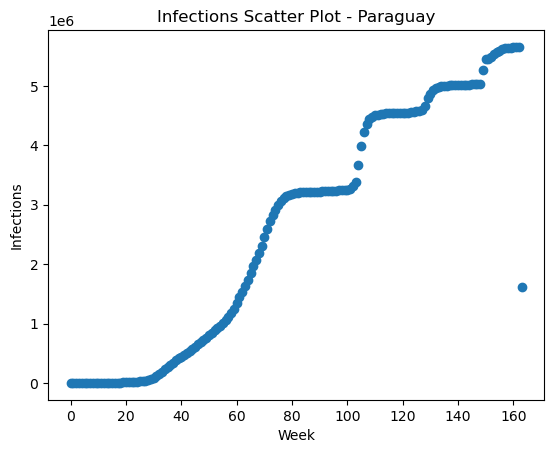

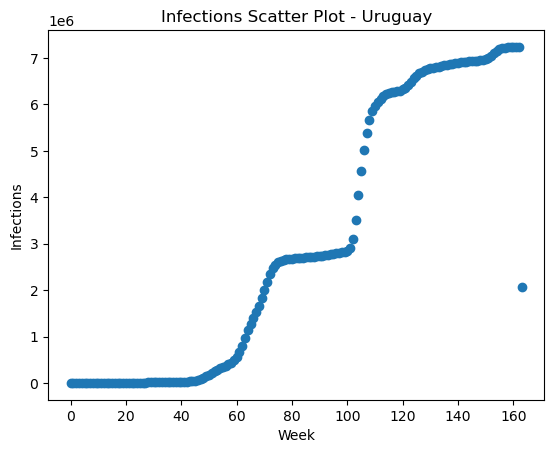

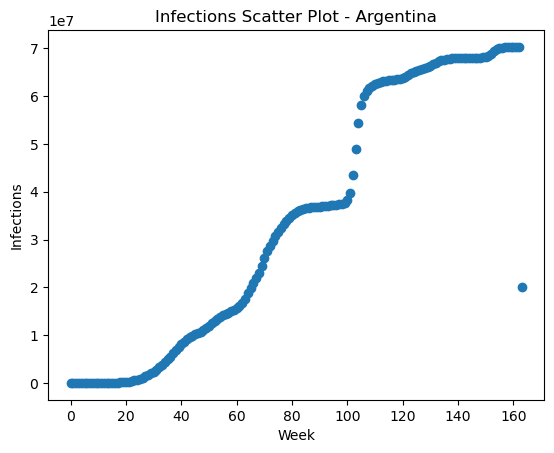

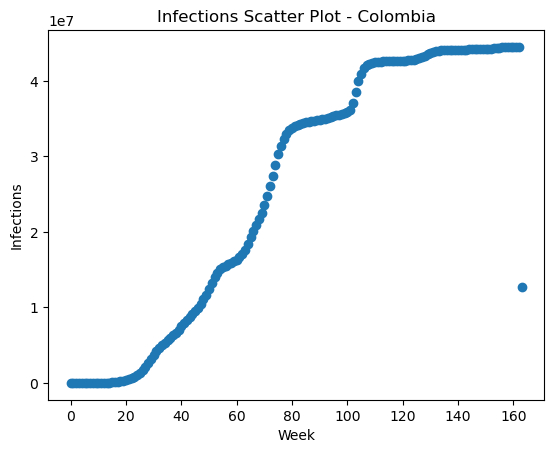

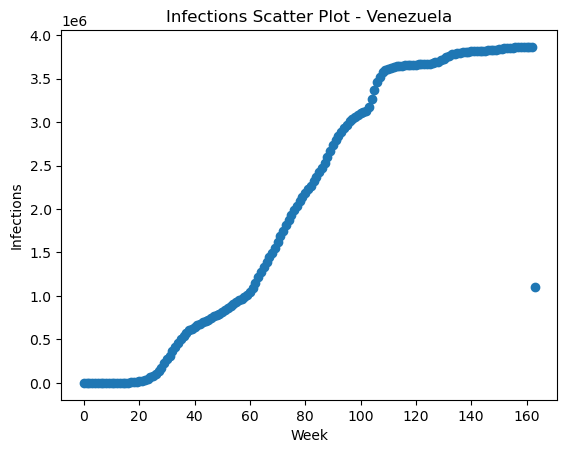

In [77]:
for country in df_southAmerica.columns:
    plt.scatter(range(len(df_southAmerica)), df_southAmerica[country])
    plt.xlabel('Week')
    plt.ylabel('Infections')
    plt.title(f'Infections Scatter Plot - {country}')
    plt.show()